#  Imports

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras import Model , layers, Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [4]:
# Cargar datasets sin etiquetas (sólo imágenes)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

# Función para convertir imagen RGB -> escala de grises (como input) y conservar RGB original como target
def rgb_to_grayscale_input(image):
    image = tf.cast(image, tf.float32) / 255.0  # Normalización a [0, 1]
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.grayscale_to_rgb(gray)  # Asegura que tiene shape (H, W, 3)
    return gray, image  # (input, target)

# Aplicar el mapeo, batching, prefetching
colorization_train_dataset = train_dataset.map(rgb_to_grayscale_input).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)
colorization_val_dataset = val_dataset.map(rgb_to_grayscale_input).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)
colorization_test_dataset = test_dataset.map(rgb_to_grayscale_input).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

Found 20300 files belonging to 1 classes.
Found 2900 files belonging to 1 classes.
Found 5800 files belonging to 1 classes.


In [ ]:

def unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(bn)

    # Decoder
    u1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(u1)
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    u2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u2)
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    u3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u3)
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    u4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u4)
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    # Output: 3-channel RGB image with sigmoid (for [0,1] range)
    outputs = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(c8)

    return Model(inputs, outputs, name="U-Net_Colorization")


unet_model = unet((128, 128, 3))


unet_model.summary()

Model: "U-Net_Colorization"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                

In [8]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [7]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="mse",metrics=["mae", psnr, ssim])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_unet_colorization.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]
history = unet_model.fit(
    colorization_train_dataset,  # tf.data.Dataset o generator
    verbose=1,  # Mostrar progreso
    validation_data=colorization_test_dataset,  # validación con rotaciones también
    epochs=75,
    callbacks=callbacks,
)


Epoch 1/75
2538/2538 [==============================] - 259s 94ms/step - loss: 0.0269 - mae: 0.1191 - psnr: 17.0180 - ssim: 0.6284 - val_loss: 0.0148 - val_mae: 0.0866 - val_psnr: 19.1343 - val_ssim: 0.7662 - lr: 1.0000e-05
Epoch 2/75
2538/2538 [==============================] - 238s 93ms/step - loss: 0.0139 - mae: 0.0827 - psnr: 19.5123 - ssim: 0.8055 - val_loss: 0.0128 - val_mae: 0.0770 - val_psnr: 20.0428 - val_ssim: 0.8365 - lr: 1.0000e-05
Epoch 3/75
2538/2538 [==============================] - 239s 94ms/step - loss: 0.0125 - mae: 0.0772 - psnr: 20.1069 - ssim: 0.8495 - val_loss: 0.0115 - val_mae: 0.0740 - val_psnr: 20.4665 - val_ssim: 0.8641 - lr: 1.0000e-05
Epoch 4/75
2538/2538 [==============================] - 239s 93ms/step - loss: 0.0118 - mae: 0.0742 - psnr: 20.4542 - ssim: 0.8678 - val_loss: 0.0112 - val_mae: 0.0719 - val_psnr: 20.6555 - val_ssim: 0.8727 - lr: 1.0000e-05
Epoch 5/75
2538/2538 [==============================] - 237s 93ms/step - loss: 0.0113 - mae: 0.0721 - ps

<Figure size 1200x1200 with 0 Axes>

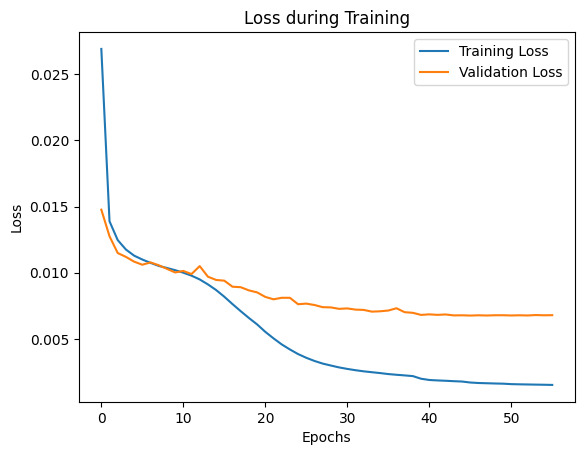

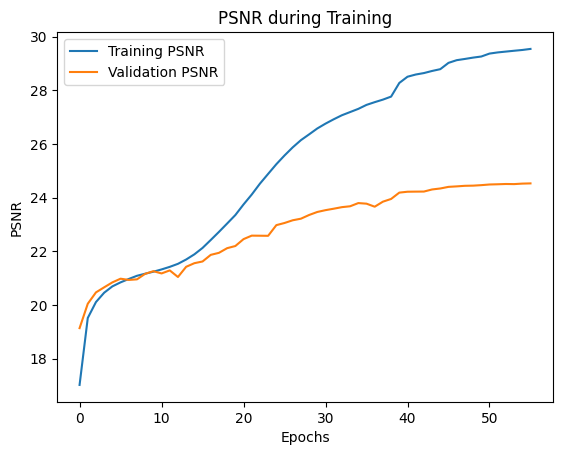

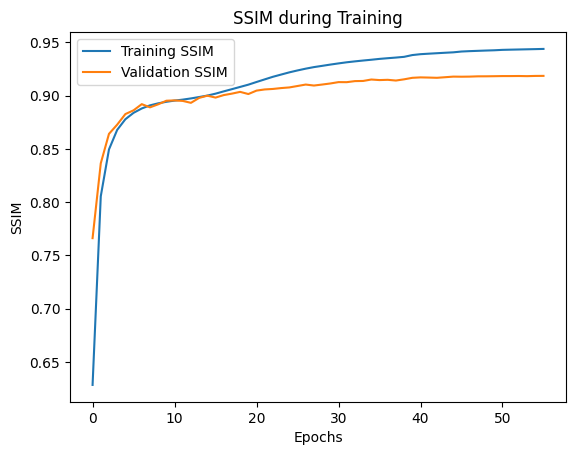

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

1/1 [==============================] - 0s 41ms/step


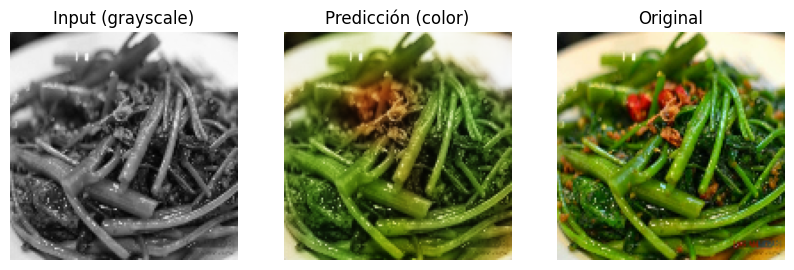

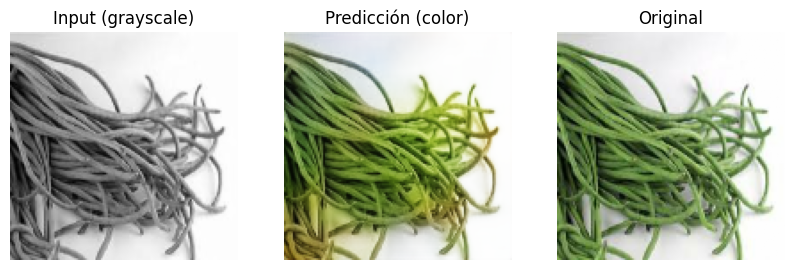

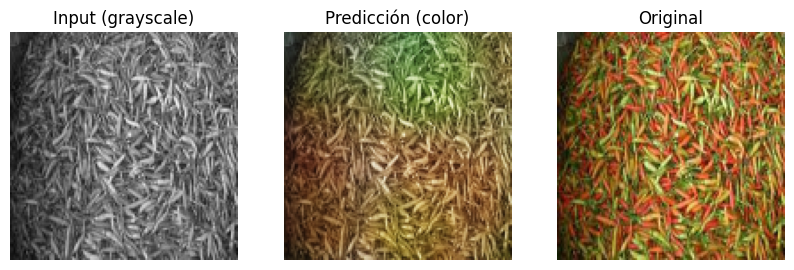

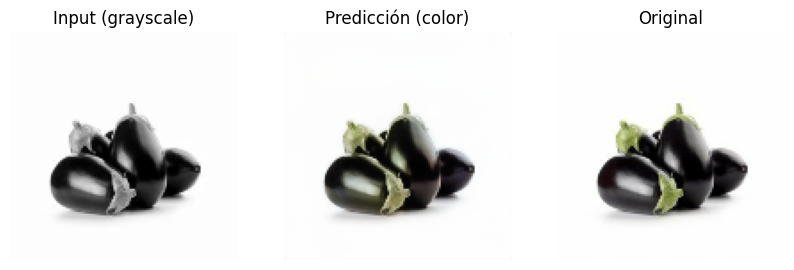

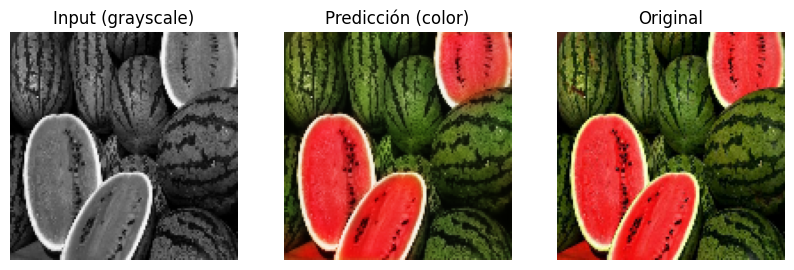

In [17]:
def show_colorization_examples(dataset, model, n=5):
    for images_gray, images_real in dataset.take(1):
        preds = model.predict(images_gray)

        for i in range(n):
            plt.figure(figsize=(10, 3))

            plt.subplot(1, 3, 1)
            plt.imshow(images_gray[i])
            plt.title("Input (grayscale)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(preds[i])
            plt.title("Predicción (color)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(images_real[i])
            plt.title("Original")
            plt.axis("off")

            plt.show()
show_colorization_examples(colorization_val_dataset, unet_model, n=5)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=16,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)



test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=16,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=16,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)


normalization_layer = tf.keras.layers.Rescaling(1./255)


# Normalización
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)


Found 20300 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.


In [11]:
model = tf.keras.models.load_model("best_unet_colorization.h5", custom_objects={'psnr': psnr, 'ssim': ssim})
autoencoder=model
autoencoder.trainable = False
autoencoder.summary()

Model: "U-Net_Colorization"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                

In [24]:
# def get_encoder(autoencoder):
#     # Extraemos las capas del encoder (hasta MaxPooling2D final)
#     for layer in autoencoder.layers:
#         layer.trainable = False
#     encoder = tf.keras.Sequential(autoencoder.layers[:13])
#     for layer in encoder.layers:
#         layer.trainable = False
#     return encoder
# encoder = get_encoder(model)
encoder_output = autoencoder.layers[14].output  # cuello en 13
encoder_model = Model(inputs=autoencoder.input, outputs=encoder_output, name="UNet_Encoder")
encoder_model.layers[-1].trainable = True  
#descongela las ultimas  4 capas
encoder_model.summary()

Model: "UNet_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [25]:
from tensorflow import keras
def create_classifier(encoder, num_classes=30, train_encoder=False):
    # for layer in encoder.layers:
    #     layer.trainable = False

    # model = tf.keras.Sequential([
    #     tf.keras.Input(shape=(128, 128, 3)),
    #     encoder,
    #     layers.GlobalAveragePooling2D(),
    #     layers.BatchNormalization(),
    #     layers.Dense(512, activation='relu'),
    #     layers.Dropout(0.3),
    #     layers.BatchNormalization(),
    #     layers.Dense(256, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.3),
    #     layers.Dense(128, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.5),
    #     layers.Dense(num_classes, activation='softmax')
    # ])
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = encoder_model(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(29, activation='softmax')(x)
    unet_clas = Model(inputs=inputs, outputs=outputs, name="UNet_Classifier")
    return unet_clas


In [26]:


classifier = create_classifier(encoder_model, num_classes=29, train_encoder=False)
classifier.summary()

Model: "UNet_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 UNet_Encoder (Functional)   (None, 8, 8, 1024)        18843200  
                                                                 
 layer_normalization_1 (Laye  (None, 8, 8, 1024)       2048      
 rNormalization)                                                 
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_6 (Batc  (None, 1024)         

In [31]:



# classifier.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# history=classifier.fit(
#     classification_train_dataset,  # dataset con labels
#     validation_data=classification_val_dataset,
#     epochs=50,
#     batch_size=64,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verboe=1),
#         tf.keras.callbacks.ModelCheckpoint("best_unetr.h5", save_best_only=True)
#     ]
# )
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = classifier.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("best_unet_classifier.h5", save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5,factor=0.5, min_lr=1e-6, verbose=1)
    ]
)
# save
classifier.save("best_classifier_unet.h5")



Epoch 1/100
1269/1269 [==============================] - 55s 35ms/step - loss: 4.7491 - accuracy: 0.2078 - val_loss: 4.1104 - val_accuracy: 0.3291 - lr: 1.0000e-05
Epoch 2/100
1269/1269 [==============================] - 47s 30ms/step - loss: 4.2286 - accuracy: 0.3055 - val_loss: 3.8458 - val_accuracy: 0.3976 - lr: 1.0000e-05
Epoch 3/100
1269/1269 [==============================] - 46s 30ms/step - loss: 3.8309 - accuracy: 0.3890 - val_loss: 3.6616 - val_accuracy: 0.4426 - lr: 1.0000e-05
Epoch 4/100
1269/1269 [==============================] - 45s 29ms/step - loss: 3.4730 - accuracy: 0.4781 - val_loss: 3.5116 - val_accuracy: 0.4886 - lr: 1.0000e-05
Epoch 5/100
1269/1269 [==============================] - 45s 29ms/step - loss: 3.1740 - accuracy: 0.5586 - val_loss: 3.4533 - val_accuracy: 0.5095 - lr: 1.0000e-05
Epoch 6/100
1269/1269 [==============================] - 45s 29ms/step - loss: 2.8807 - accuracy: 0.6361 - val_loss: 3.3546 - val_accuracy: 0.5378 - lr: 1.0000e-05
Epoch 7/100
1269

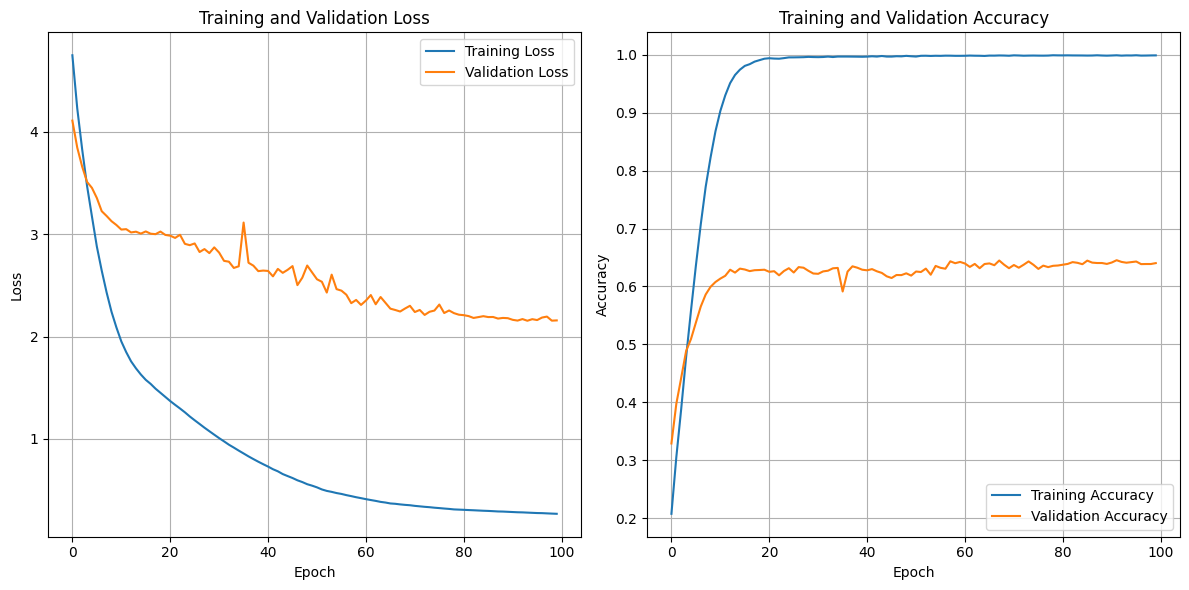

In [32]:
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 352ms/step
Accuracy de validación: 0.70


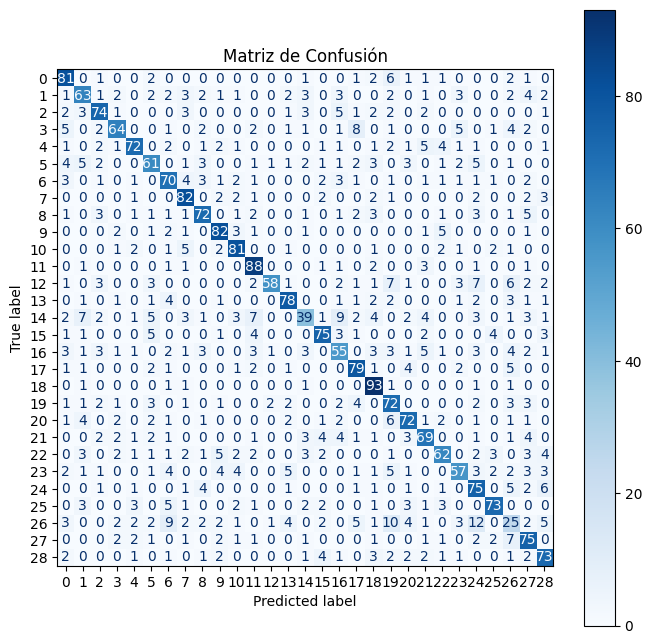

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import keras
#load the best model

# Load the best model with custom objects
model_ = keras.models.load_model("best_classifier_unet.h5")
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model_.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
# elmina la etiqueta 3
# y_true = [label for label in y_true if label != 3]
# y_pred = [pred for pred, label in zip(y_pred, y_true) if label != 3]
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión")
plt.show()


1/1 [==============================] - 0s 19ms/step


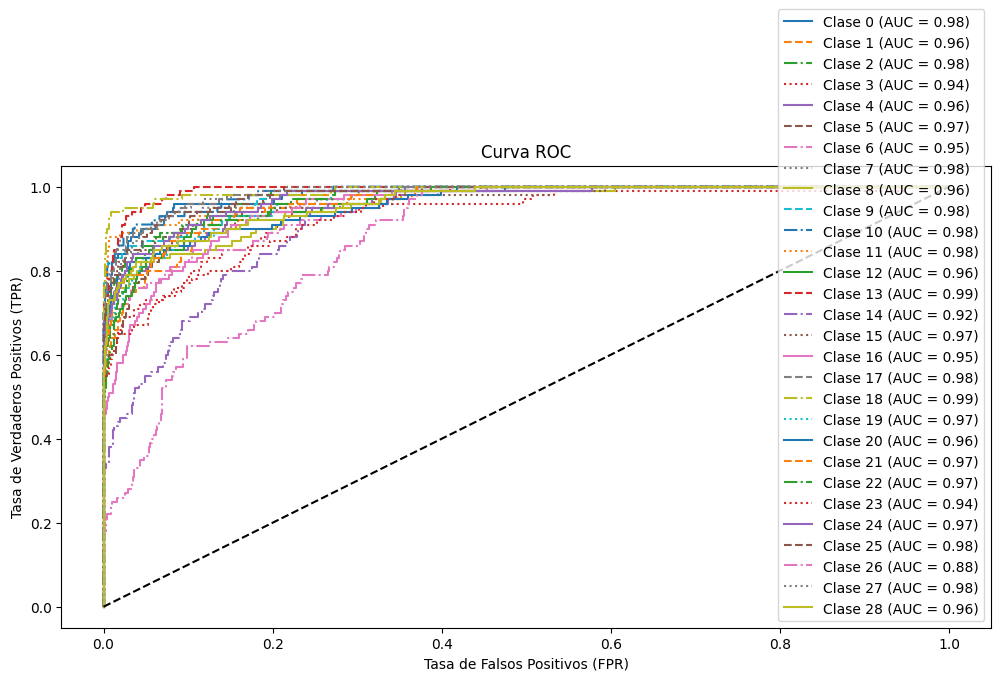

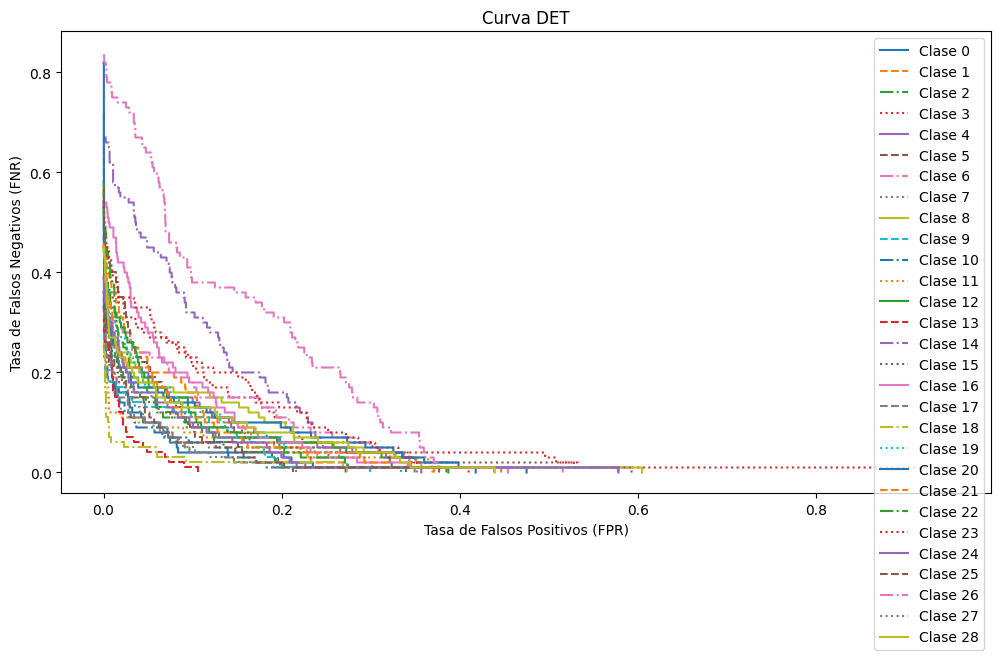

In [35]:
from sklearn.metrics import roc_curve, det_curve, auc

import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = classifier.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
line_styles = ['-', '--', '-.', ':']  # Diferentes estilos de línea
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})', linestyle=line_styles[i % len(line_styles)])

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}', linestyle=line_styles[i % len(line_styles)])
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()
